<a href="https://colab.research.google.com/github/AKUG47/BPE-pytorch/blob/master/softmax_linreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip install d2l torchvision

In [45]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
from IPython import display

d2l.use_svg_display()

In [46]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [47]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [48]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [49]:
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [50]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

torch.Size([18, 1, 28, 28])


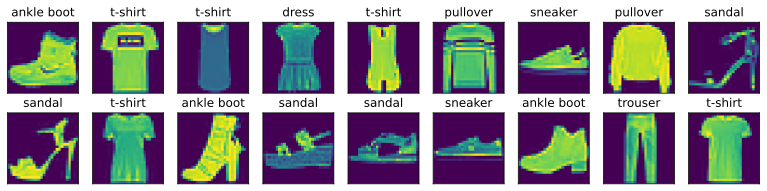

In [51]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
print(X.shape)
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [52]:
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


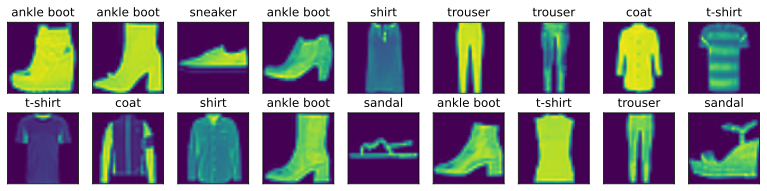

In [53]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    show_images(X.reshape(32, 64, 64), 2, 9, titles=get_fashion_mnist_labels(y))
    break

In [54]:
def softmax(X):
    X_exps = torch.exp(X)
    partition = X_exps.sum(dim=1, keepdim=True)
    return X_exps / partition

In [55]:
for X, y in train_iter:
    # print(X.reshape(-1, W.shape[0]).shape, X.shape, y.shape)
    print(y)
    # show_images(X.reshape(32, 64, 64), 2, 9, titles=get_fashion_mnist_labels(y))
    break

tensor([4, 6, 4, 1, 2, 8, 9, 4, 3, 0, 9, 1, 2, 9, 8, 2, 0, 3, 0, 5, 8, 4, 2, 4,
        4, 8, 4, 2, 5, 8, 2, 7])


In [56]:
def softmax_linreg(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]), W) + b)

In [57]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

In [58]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [59]:
class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [ a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def getitem(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), len(y))

    return metric.getitem(0) / metric.getitem(1)


In [60]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [61]:
def train_epoch_ch3(net, train_iter, loss, updater):
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater([W, b], lr, X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())

    return metric.getitem(0) / metric.getitem(2), metric.getitem(1) / metric.getitem(2)



In [62]:
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [63]:
def train_ch3(train_iter, test_iter, loss, net, updater, num_epochs):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc >0.7, test_acc

In [69]:
num_inputs = 784
num_outputs = 10
batch_size = 256

train_iter, test_iter = load_data_fashion_mnist(batch_size)
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

print(f"W: {W}:2f")
print(f"b: {b}:2f")

W: tensor([[-0.0064, -0.0013,  0.0025,  ...,  0.0074,  0.0157,  0.0033],
        [-0.0080,  0.0041, -0.0030,  ...,  0.0102,  0.0019,  0.0023],
        [-0.0103,  0.0018, -0.0086,  ..., -0.0096,  0.0079,  0.0045],
        ...,
        [-0.0061,  0.0139,  0.0094,  ..., -0.0055, -0.0035, -0.0063],
        [ 0.0100,  0.0107,  0.0084,  ...,  0.0158,  0.0008, -0.0163],
        [-0.0038,  0.0152,  0.0133,  ..., -0.0048, -0.0091, -0.0021]],
       requires_grad=True):2f
b: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True):2f


In [70]:
print(f"W: {W}:2f")
print(f"b: {b}:2f")

W: tensor([[-0.0064, -0.0013,  0.0025,  ...,  0.0074,  0.0157,  0.0033],
        [-0.0080,  0.0041, -0.0030,  ...,  0.0102,  0.0019,  0.0023],
        [-0.0103,  0.0018, -0.0086,  ..., -0.0096,  0.0079,  0.0045],
        ...,
        [-0.0061,  0.0139,  0.0094,  ..., -0.0055, -0.0035, -0.0063],
        [ 0.0100,  0.0107,  0.0084,  ...,  0.0158,  0.0008, -0.0163],
        [-0.0038,  0.0152,  0.0133,  ..., -0.0048, -0.0091, -0.0021]],
       requires_grad=True):2f
b: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True):2f


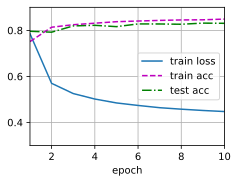

In [71]:
net = softmax_linreg
loss = cross_entropy
updater = sgd
lr = 0.1
num_epochs = 10

train_ch3(train_iter, test_iter, loss, net, updater, num_epochs)

In [72]:
print(f"W: {W}:2f")
print(f"b: {b}:2f")

W: tensor([[-0.0064, -0.0013,  0.0024,  ...,  0.0074,  0.0157,  0.0033],
        [-0.0076,  0.0041, -0.0030,  ...,  0.0102,  0.0016,  0.0023],
        [-0.0085,  0.0015, -0.0087,  ..., -0.0097,  0.0054,  0.0043],
        ...,
        [-0.0367,  0.0101,  0.0517,  ..., -0.0141, -0.0434, -0.0113],
        [-0.0019,  0.0103,  0.0201,  ...,  0.0129, -0.0180, -0.0149],
        [-0.0043,  0.0148,  0.0164,  ..., -0.0053, -0.0129, -0.0015]],
       requires_grad=True):2f
b: tensor([ 0.2833, -0.2980, -0.0913,  0.1850, -0.9110,  1.8998,  0.4228, -0.1084,
        -0.4329, -0.9493], requires_grad=True):2f


In [77]:
def predict(net, test_iter):
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    show_images(X.reshape(X.shape[0], 28, 28), 1, 9, titles=titles[0:9])

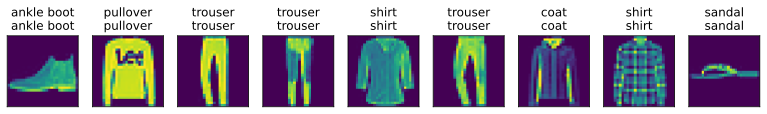

In [78]:
predict(net, test_iter)

In [80]:
torch.exp(torch.tensor([50]))

tensor([5.1847e+21])